In [2]:
import testing as tst
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pickle import load, dump 
import math
import datetime

# Import data, model, scalers, in_size

In [24]:
nombres1=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Presion','alturasolar','azimuth']
esoru=tst.importa('../../01_weather_data/02_cleaned_data/esoru_night_angles_2.csv',nombres1)
dias_rango=3
forward_steps=dias_rango*144
in_size,out_size= 6,6 
istep=0
model_name='../02_grid_training/01_models/train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_0.0001_Global_BS24.h5'
model=tst.load_model(model_name)
inputs=['Global','Direct','Temperatura','Humedad','azimuth','alturasolar']
outputs=['Global']
training_step=1
season_size=144
scalery=load(open('../02_grid_training/03_scalers/y_scalerv01.pkl','rb'))
scalerx=load(open('../02_grid_training/03_scalers/x_scalerv01.pkl','rb'))

predi,targ=tst.Multioneshot(esoru,forward_steps,out_size,in_size,istep,model,inputs,outputs,training_step,season_size,scalerx,scalery)

## Exporta takes  the imputed data, on the wanted index 

In [25]:
impesoru=tst.seasonal_exporta('../../01_weather_data/02_cleaned_data/esoru_night_angles_2.csv',predi,istep,in_size,forward_steps,season_size,nombres1,sol_data_correction=True)
impesoru_target=pd.read_csv('../../01_weather_data/02_cleaned_data/esoru_night_angles_2.csv',names=nombres1,index_col=0,parse_dates=True,skiprows=1)


/Users/aigz/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [26]:
 yearly,daily,hourly=tst.dfmetricas(impesoru,impesoru_target,'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_0.0001_Global_BS24.h5')
 yearly  

,Direct,Global,Difusa,Temperatura,Humedad,Presion,alturasolar,azimuth,prediccion,minutodia,me,mae,E_d,Ep_d,E_dmape,E_dmae,mae_Ig,model
tiempo,,,,,,,,,,,,,,,,,,
2019-12-31,233.00458,257.889782,69.498388,23.801579,55.550039,876.150209,-0.000049,0.152425,258.071825,715.0,0.182043,0.395721,6186.887394,6191.256436,0.163124,6.429473,0.791615,train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_0...


### Visualization

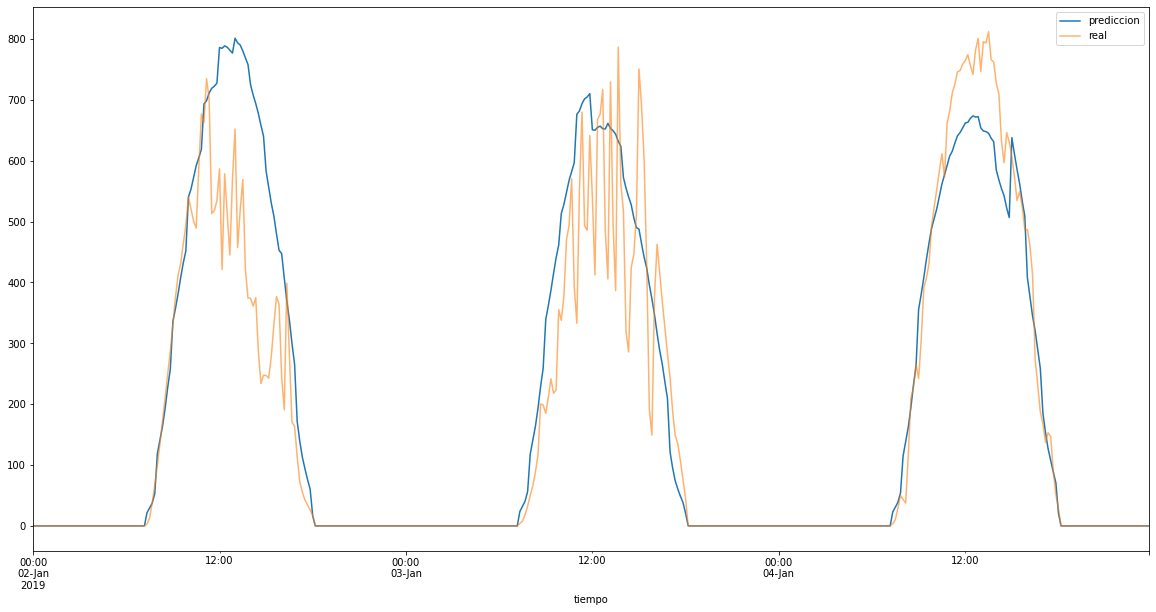

In [31]:
rango=forward_steps
impesoru.Global[istep+144:istep+rango+144].plot(figsize=(20,10),alpha=1,label='prediccion')
impesoru_target.Global[istep+144:istep+rango+144].plot(alpha=.6,label='real')
plt.legend()

# MAE typical day

diferencia absoluta [w/m2] promedio anual por hora: 0.17318377011012873


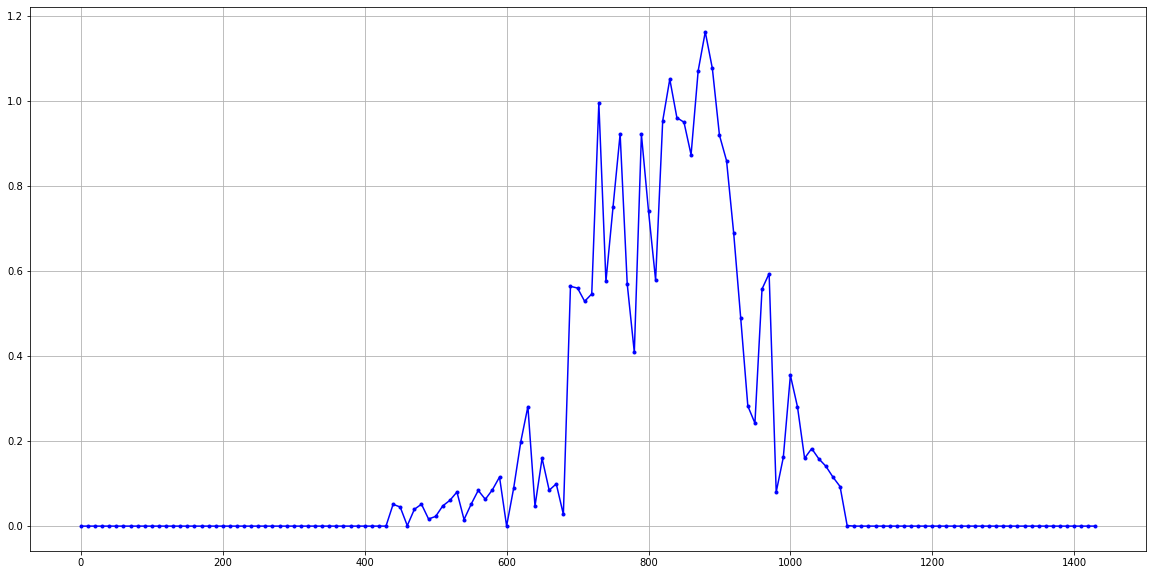

In [8]:
dfrad=impesoru_target.copy()
dfrad['prediccion']=impesoru.Global.copy().astype(float)
dfrad['minutodia']=(dfrad.index.hour*60)+dfrad.index.minute
dfrad['me']=(dfrad.prediccion-dfrad.Global).astype(float)
dfrad['mae']=np.abs(dfrad.Global-dfrad.prediccion).astype(float)
#dfrad.groupby(dfrad.index.to_period('T'))
#Typical day MAE
dfmingroup=dfrad.groupby(['minutodia',pd.Grouper(freq='1H')]).mean()#Agrupaci'on de los promedios de todos los días del año a la misma hora del día 
dfmindia=dfmingroup.groupby(pd.Grouper(level='minutodia',axis=0)).mean() #Se hace un promedio de estos valores (dfmindia)
dfmingroup#['Global','prediccion','mae']
 #Constructing a characteristic mae day
meanaltura=dfmindia.alturasolar.mean()
fig, ax= plt.subplots(figsize=(20,10))
# dfmindia.loc[dfmindia.alturasolar<0,'mae']=np.nan #delete the night values 
meandiay=dfmindia.mae.mean()
ax.plot(dfmindia.mae,'b.-')
plt.grid()
print('diferencia absoluta [w/m2] promedio anual por hora:',meandiay) 


(0.0, 300.0)

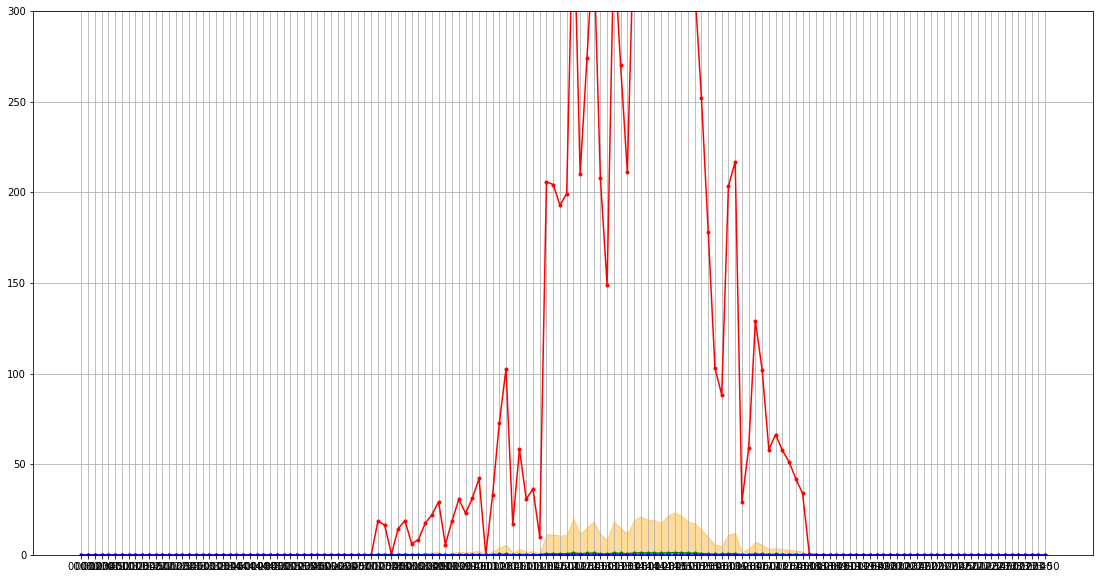

In [9]:
fig, ax= plt.subplots(figsize=(19,10))
dfted=dfrad.mae.groupby(by=[dfrad.index.strftime('%H:%M')]).agg(['mean','std','max','min'])
ax.plot(dfted['mean'],'g.-')
ax.fill_between(dfted.index,dfted['mean']+dfted['std'],dfted['mean']-dfted['std'],color='orange', alpha=0.4)
ax.plot(dfted['max'],'r.-')
ax.plot(dfted['min'],'b.-')
ax.grid()
plt.ylim(0,300)

# Metrics cycle to grid search selection

In [19]:
tabnames=[]
for i in range(1,10,1):
    for o in range (1,4,1):
        tabnames.append(str(i)+str(o)+'.csv')
print(tabnames)

['11.csv', '12.csv', '13.csv', '21.csv', '22.csv', '23.csv', '31.csv', '32.csv', '33.csv', '41.csv', '42.csv', '43.csv', '51.csv', '52.csv', '53.csv', '61.csv', '62.csv', '63.csv', '71.csv', '72.csv', '73.csv', '81.csv', '82.csv', '83.csv', '91.csv', '92.csv', '93.csv']


In [19]:
#Input data
print('This process may replace the imputed years files, and can last up to 2 hours')
answer=input('Do you still want to proceed? y/n')
if str(answer)=='y':
    print('then proceed')
    nombres1=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Presion','alturasolar','azimuth']
    esoru=tst.importa('../../01_weather_data/02_cleaned_data/esoru_night_angles_2.csv',nombres1)
    dias_rango=363
    forward_steps=dias_rango*144
    in_size,out_size= 6,6 
    istep=0
    inputs=['Global','Direct','Temperatura','Humedad','azimuth','alturasolar']
    outputs=['Global']
    training_step=1
    season_size=144
    scalery=load(open('../02_grid_training/03_scalers/y_scalerv09.pkl','rb'))
    scalerx=load(open('../02_grid_training/03_scalers/x_scalerv09.pkl','rb'))


    tablita=['model','dif_energia_wh','porcentaje_energia_daily','porcentaje_mae','mae_Ig','mae_daily']

    # tablita=['model','dif_energia_wh','porcentaje_energia','porcentaje_mae','mae_de_día_promedio']
    pathtab='4'
    nombre_archivotab='metricas_tabla_all.csv'#'metricas_tabla_all.csv'
    path_models='../02_grid_training/01_models/'
    listmodels=['train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_1e-07_Global_BS6.h5',
    'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_1e-07_Global_BS12.h5',
    'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_1e-07_Global_BS24.h5',
    'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_1e-05_Global_BS6.h5',
    'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_1e-05_Global_BS12.h5',
    'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_1e-05_Global_BS24.h5',
    'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_0.0001_Global_BS6.h5',
    'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_0.0001_Global_BS12.h5',
    'train_seasonal_layers_3_3_1_out_s_6in_s_6_lr_0.0001_Global_BS24.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_1e-07_Global_BS6.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_1e-07_Global_BS12.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_1e-07_Global_BS24.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_1e-05_Global_BS6.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_1e-05_Global_BS12.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_1e-05_Global_BS24.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_0.0001_Global_BS6.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_0.0001_Global_BS12.h5',
    'train_seasonal_layers_2_2_1_out_s_6in_s_6_lr_0.0001_Global_BS24.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_1e-07_Global_BS6.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_1e-07_Global_BS12.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_1e-07_Global_BS24.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_1e-05_Global_BS6.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_1e-05_Global_BS12.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_1e-05_Global_BS24.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_0.0001_Global_BS6.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_0.0001_Global_BS12.h5',
    'train_seasonal_layers_1_1_1_out_s_6in_s_6_lr_0.0001_Global_BS24.h5']
    #cycle
    imputed_list=['11.csv', '12.csv', '13.csv', 
     '21.csv', '22.csv', '23.csv', 
     '31.csv', '32.csv', '33.csv', 
     '41.csv', '42.csv', '43.csv', 
     '51.csv', '52.csv', '53.csv',
     '61.csv', '62.csv', '63.csv', 
     '71.csv', '72.csv', '73.csv',
     '81.csv', '82.csv', '83.csv', 
     '91.csv', '92.csv', '93.csv']
    for heo in range(len(listmodels)):
        model=tst.load_model(path_models+listmodels[heo])

        print(str(heo+1)+' iteration from '+str(len(listmodels))+' total iterations')
        predi,targ=tst.Multioneshot(esoru,forward_steps,out_size,in_size,istep,model,inputs,outputs,training_step,season_size,scalerx,scalery)
        impesoru=tst.seasonal_exporta('../../01_weather_data/02_cleaned_data/esoru_night_angles_2.csv',predi,istep,in_size,forward_steps,season_size,nombres1,sol_data_correction=True,save=True,archivo_nombre=imputed_list[heo])
        impesoru_target=pd.read_csv('../../01_weather_data/02_cleaned_data/esoru_night_angles_2.csv',names=nombres1,index_col=0,parse_dates=True,skiprows=1)
        yearly,daily,hourly=tst.dfmetricas(impesoru,impesoru_target,listmodels[heo])
        if heo==0:
            tst.begin_table(yearly,tablita,pathtab,nombre_archivotab)
        if heo>0:
            met=tst.actualizar_bitacora(yearly,tablita,pathtab,nombre_archivotab)
else :
    print('understandable have a nice day')

This process may replace the imputed years files, and can last up to 2 hours
Do you still want to proceed? y/nn
understandable have a nice day
